In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

In [2]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [3]:
# Generate random variables
x = np.random.uniform(0, 1, size=(1000, 2))
y = np.array([1. if (xi[0]**2 + xi[1]**2 <= 1) else 0. for xi in x]).astype('float32')

In [4]:
x

array([[0.5521398 , 0.88265465],
       [0.11268458, 0.49652862],
       [0.08557695, 0.78476119],
       ...,
       [0.17844799, 0.80856754],
       [0.29269689, 0.43126234],
       [0.18977255, 0.16642845]])

In [5]:
y[:10]

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 0.], dtype=float32)

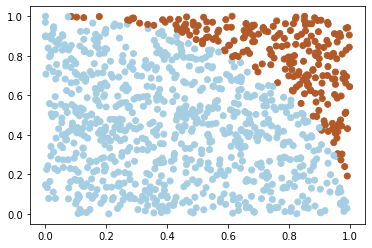

In [6]:
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='Paired_r')

In [7]:
# Indices of data points in the current region
def in_region(data, region):
  '''
  data: an array of size (n, 2)
  region: an array of size (1, 2**2)
  returns array
  '''
  return np.where((region[0] <= data[:, 0]) & (data[:, 0] < region[1]) & (region[2] <= data[:, 1]) & (data[:, 1] < region[3]))

In [8]:
def decision_tree(x, y):
  all_preds = np.zeros_like(y)
  shat = y
  for p in range(1):
    preds = np.zeros_like(y)
    regions = np.array([0, 1, 0, 1]).reshape((1, 4))
    for num in range(1):
      new_regions = np.zeros((1, 4))
      region_to_delete = -1
      for i, M in enumerate(regions):
        x_in_region = x[in_region(x, M)]
        min_loss = np.infty
        losses = np.array((2, 0))
        for j in [0, 1]:
          # We don't want to consider the "end points", i.e. we shouldn't cut off at a leftmost or rightmost point, we would then be creating an empty region...
          possible_cutoffs = np.sort(x_in_region[:, j])[1:-1]
          for xij in possible_cutoffs:
            added_loss = 0
            # Define cut/new region to make
            if (j == 0):
              new_region_1 = np.array([M[0], xij, M[2], M[3]]).reshape((4, ))
              new_region_2 = np.array([xij, M[1], M[2], M[3]]).reshape((4, ))
            if (j == 1):
              new_region_1 = np.array([M[0], M[1], xij, M[3]]).reshape((4, ))
              new_region_2 = np.array([M[0], M[1], M[2], xij]).reshape((4, ))  
            
            for new_region in [new_region_1, new_region_2]:
              new_idx = in_region(x, new_region)
              phat = np.mean(y[new_idx])
              added_loss += np.sum((shat[new_idx] - phat)**2)

            if added_loss < min_loss:   
              #print("this is the best cutoff SO FAR")
              min_loss = added_loss

              good_region_1 = new_region_1
              good_region_2 = new_region_2

              new_idx_1 = in_region(x, good_region_1)
              new_idx_2 = in_region(x, good_region_2)

              phat_1 = np.mean(y[new_idx_1])
              phat_2 = np.mean(y[new_idx_2])

          preds[in_region(x, good_region_1)] = phat_1
          preds[in_region(x, good_region_2)] = phat_2

          new_regions = np.vstack([new_regions[:-2], good_region_1, good_region_2])
          region_to_delete = i
            
      # Change regions here
      regions = np.delete(regions, region_to_delete, axis=0)
      regions = np.vstack([regions, new_regions], )

  return preds


In [9]:
def xg_wu(x, y, num):
  preds = decision_tree(x, y)
  resid = y - sigmoid(preds)
  for i in range(num):
    preds += decision_tree(x, resid)
    #print(preds[:10])
    print(roc_auc_score(y, sigmoid(preds)))
    resid = y - sigmoid(preds)
  return sigmoid(preds)

In [10]:
good_preds = xg_wu(x, y, 100)
preds_list = [1. if p >= 0.5 else 0. for p in good_preds]

0.9063466967814794
0.924059853190288
0.9573856578204405
0.9472586109542632
0.9653896103896104
0.965643704121965
0.9707538114059854
0.9709345002823263
0.9782608695652173
0.9810163749294185
0.9842518351214004
0.9807114624505928
0.9823037831733484
0.981400338791643
0.9862761151891587
0.988249576510446
0.9886278938452852
0.988102766798419
0.9902936194240541
0.9898447204968944
0.9903754940711463
0.9906013551665727
0.9915217391304347
0.9909796725014117
0.9911264822134387
0.9913466967814795
0.9924816487859965
0.9922501411631848
0.9923630717108978
0.9940005646527386
0.9947910784867305
0.9941784302653868
0.9941389045736873
0.995183512140034
0.9958159232072277
0.9955279503105591
0.9946753246753246
0.9956634669678148
0.9962168266516093
0.9956775832862789
0.995711462450593
0.9960559006211179
0.9955251270468661
0.9958752117447771
0.9963099943534727
0.996569734613213
0.9969028797289667
0.9960841332580463
0.9970892151326933
0.9972755505364201
0.9969706380575947
0.9960135516657256
0.9971146245059288
0

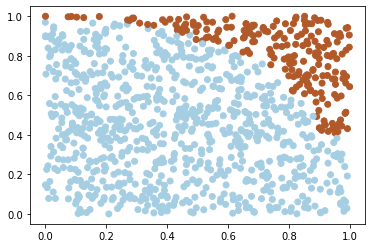

In [11]:
plt.scatter(x[:, 0], x[:, 1], c=preds_list, cmap='Paired_r')